In [1]:
import os, math
from enum import StrEnum, auto
from collections import defaultdict, namedtuple, Counter
import itertools
import sqlite3
import pickle
import datetime
import multiprocessing as mp
import gc
import json
import decimal
from IPython.core.getipython import get_ipython

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

with open(get_ipython().kernel.config['IPKernelApp']['connection_file'], 'r') as cf:
    notebook_fname = json.load(cf)['jupyter_session']
    notebook_fname = os.path.basename(notebook_fname)

print(notebook_fname)

xp = cupy
transf_learn5.ipynb


In [3]:
%run sequencing_sp2.ipynb

# Open DB

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)
transfs_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.transfs_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

if not DBUtils.is_table_exists(transfs_db_con, 'pixels'):
    transfs_db_con.execute('CREATE TABLE pixels(encoding, sbv)')

if not DBUtils.is_table_exists(transfs_db_con, 'clusters'):
    transfs_db_con.execute('CREATE TABLE clusters(encoding, transf_code, output_bit, sbv, meta)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 10 μs, sys: 0 ns, total: 10 μs
Wall time: 18.1 μs


((10000, 7), (2000, 7))


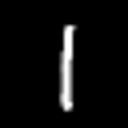
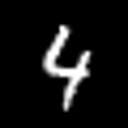
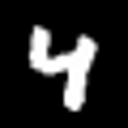
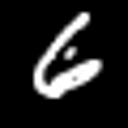
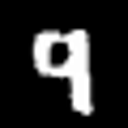
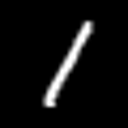
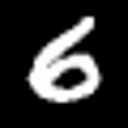
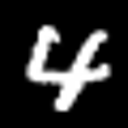
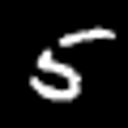
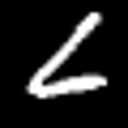
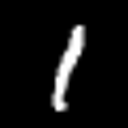
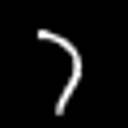
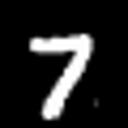
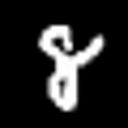
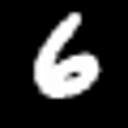
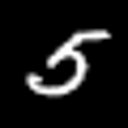

In [5]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Hyper Parameters

In [6]:
# HP_SIGNAL_VEC_LEN = 2000 # aka SBV
# HP_SIGNAL_VEC_NON_ZERO_BITS = 9
# HP_SIGNAL_ENCODING = f'{HP_SIGNAL_VEC_LEN}/{HP_SIGNAL_VEC_NON_ZERO_BITS}'

# HP_CLUSTER_ONES_COUNT_THRES = 5
# HP_CLUSTER_CREATION_ONES_COUNT_THRES = 6
# HP_CLUSTER_LEARN_STATE_IDLE_CYCLES = 10
# HP_CLUSTER_PREPROD_STATE_IDLE_CYCLES = 30
# HP_CLUSTER_LEARN_STATE_BINARIZE_SCHEDULE = (10, 20)
# HP_CLUSTER_PREPROD_STATE_SIGNALS_PROCESSED_THRES = 10
# HP_CLUSTER_BINARIZE_THRES = 0.75
# HP_CLUSTER_ACCURACY_THRES = 0.75

# HP_PIXELS_COUNT = config.sample_size ** 2

HP_SIGNAL_VEC_LEN = 256 # aka SBV
HP_SIGNAL_VEC_NON_ZERO_BITS = 6
HP_SIGNAL_ENCODING = f'{HP_SIGNAL_VEC_LEN}/{HP_SIGNAL_VEC_NON_ZERO_BITS}'

HP_CLUSTER_ONES_COUNT_THRES = 3
HP_CLUSTER_CREATION_ONES_COUNT_THRES = 4
HP_CLUSTER_LEARN_STATE_IDLE_CYCLES = 10
HP_CLUSTER_PREPROD_STATE_IDLE_CYCLES = 30
HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE = (10, 10)
HP_CLUSTER_PREPROD_STATE_SIGNALS_PROCESSED_THRES = 20
HP_CLUSTER_BINARIZE_THRES = 0.75
HP_CLUSTER_ACCURACY_THRES = 0.95

HP_TOY_IMAGE_SIZE = 10
HP_TOY_IMAGE_SQUARE = HP_TOY_IMAGE_SIZE ** 2
HP_TOY_IMAGE_KERNEL_SIZE = 8
HP_TOY_IMAGE_KERNEL_SQUARE = HP_TOY_IMAGE_KERNEL_SIZE ** 2
assert HP_TOY_IMAGE_KERNEL_SIZE <= HP_TOY_IMAGE_SIZE
HP_TOY_IMAGE_ONES_COUNT = 8

HP_PIXELS_COUNT = HP_TOY_IMAGE_SQUARE

## Types

In [7]:
class ClusterState(StrEnum):
    LEARN = auto()
    PREPROD = auto()
    PROD = auto()
    DEAD = auto()

class ClusterMeta:
    def __init__(self, cluster_ind):
        self.state = ClusterState.LEARN
        self.cluster_ind = cluster_ind
        self.cluster_key = ()
        self.output_bit = -1
        self.input_bits = ()
        self.nu = 0
        self.ones_count = -1
        self.signals_learned = -1
        self.signals_to_learn_till_binarization = 0
        self.binarization_schedule = ()
        self.stats = Counter()
        self.verify_image_ids = {}
        self.alarm_cycle = None

## Memory

In [8]:
def hdv_array_log_like_grow_policy(size):
    k = math.log(size, 100_000)
    new_size = size * 2 if k < 1 else size * 1.1
    return int(new_size)

CLUSTERS = HdvArray(HP_SIGNAL_VEC_LEN, xp, initial_length=10_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy)
CLUSTER_MASKS = HdvArray(HP_SIGNAL_VEC_LEN, xp, initial_length=10_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy)
CLUSTER_METAS = {} # key - cluster index, value ClusterMeta instance

In [35]:
def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

def clear_memory():
    CLUSTER_METAS.clear()
    CLUSTER_MASKS.clear(is_hard_clear=True)
    CLUSTERS.clear(is_hard_clear=True)
    gc_memory()

## SBV

In [10]:
df_pixels = pd.read_sql('SELECT rowid, sbv FROM pixels WHERE encoding=:encoding', params={'encoding': HP_SIGNAL_ENCODING}, con=transfs_db_con)

if len(df_pixels) > 0:
    PIXEL_SBVS = pickle.loads(df_pixels.iloc[0].sbv)
    print(f'PIXEL_SBVS loaded from database (ROWID={df_pixels.iloc[0].rowid})')
else:
    PIXEL_SBVS = np.zeros((HP_PIXELS_COUNT, HP_SIGNAL_VEC_LEN), dtype='f')
    
    for i in range(PIXEL_SBVS.shape[0]):
        ii = RNG.choice(HP_SIGNAL_VEC_LEN, HP_SIGNAL_VEC_NON_ZERO_BITS, replace=False)
        PIXEL_SBVS[i][ii] = 1

    transfs_db_con.execute('INSERT INTO pixels (encoding, sbv) VALUES (:encoding, :sbv)', {'encoding': HP_SIGNAL_ENCODING, 'sbv': pickle.dumps(PIXEL_SBVS)})
    print('PIXEL_SBVS created from scratch')

assert PIXEL_SBVS.shape[0] == HP_PIXELS_COUNT
assert np.all(PIXEL_SBVS.sum(axis=1) == HP_SIGNAL_VEC_NON_ZERO_BITS)
# PIXEL_SBVS = xp_array_to_gpu(PIXEL_SBVS)

PIXEL_SBVS loaded from database (ROWID=2)


## lambdas

In [11]:
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, seq_reading_code: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), seq_reading_code))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id: Image.open(io.BytesIO((df_train_images if image_id < 100_000_000 else df_test_images).loc[image_id]['png']))
get_cluster_key = lambda tag, output_bit, input_bits: (tag, int(output_bit), tuple(map(int, sorted(input_bits))))
signal_elem_ind_to_xy = lambda ind: (int(ind % HP_COMBI_SPACE_SIZE), int(ind // HP_COMBI_SPACE_SIZE))
signal_elem_inds_to_xy = lambda inds: list(map(lambda ind: signal_elem_ind_to_xy(ind), inds))
get_cluster_logic = lambda cluster_ind: (signal_elem_inds_to_xy(xp_array_from_gpu(xp.argwhere(CLUSTERS.array_active[cluster_ind]).ravel()).astype('i')), signal_elem_ind_to_xy(CLUSTER_METAS[cluster_ind].output_bit))

## calc_seq_ipxy

In [12]:
def calc_seq_ipxy(sequences, si_ind_dict):
    unique_pts = {} # Dictionaries preserve insertion order  (https://docs.python.org/3/library/stdtypes.html#typesmapping)
        
    for sequence in sequences:
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence_fwd = np.roll(xy_sequence, -1, axis=0)
        vec_sequence = xy_sequence_fwd - xy_sequence
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        vec_len_sequence = np.round(vec_len_sequence, decimals=0).astype(int)
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        for pt, pt_to, norm_vec, vec_len in zip(xy_sequence, xy_sequence_fwd, norm_vec_sequence, vec_len_sequence):
            if vec_len <= 0:
                continue

            pts = pt + (np.arange(vec_len) * norm_vec[np.newaxis,:].T).T # path interpolation
            pts = np.round(pts, decimals=0).astype(int)
            pts = np.vstack([pts, pt_to])
            unique_pts.update(map(lambda p: (tuple(p), 1), pts))

    return np.vstack(list(unique_pts.keys()))

## calc_seq_bv

In [13]:
def calc_seq_bv(seq_xy):
    seq_xy = xp_array_to_gpu(seq_xy)
    seq_xy = seq_xy * (HP_COMBI_SPACE_SIZE / config.sample_size)
    # Leave only points which fit into square defined by HP_COMBI_CLUSTERS_SPACE_SIZE,
    # use filtering instead of clipping because clipping tends to introduce false point clustering at the bounadries
    seq_xy = xp.round(seq_xy, decimals=0)
    ii = xp.all(((seq_xy >= 0) & (seq_xy < HP_COMBI_SPACE_SIZE)), axis=1) 
    seq_xy = seq_xy[ii]
    ind_seq = (seq_xy @ xp.array([1, HP_COMBI_SPACE_SIZE])).astype(int)
    bitmap_vec = xp.zeros((HP_COMBI_SPACE_SIZE, HP_COMBI_SPACE_SIZE), dtype='f').ravel()
    bitmap_vec[ind_seq] = 1
    return bitmap_vec

## calc_seq_sbv

In [14]:
def calc_seq_sbv(seq_xy):
    ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
    seq_xy = seq_xy[ii]
    ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
    seq_sbv = np.where(np.sum(PIXEL_SBVS[ind_seq], axis=0) > 0, 1, 0) # aka Bloom filter
    return seq_sbv

In [15]:
# def calc_seq_sbv(seq_xy):
#     seq_xy = xp_array_to_gpu(seq_xy)
#     ii = xp.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
#     seq_xy = seq_xy[ii]
#     ind_seq = (seq_xy @ xp.array([1, config.sample_size])).astype(int)
#     seq_sbv = xp.where(xp.sum(PIXEL_SBVS[ind_seq], axis=0) > 0, 1, 0) # aka Bloom filter
#     return seq_sbv

## seq_sbv_to_bv

In [16]:
def seq_sbv_to_bv(seq_sbv):
    seq_sbv = xp_array_from_gpu(seq_sbv)
    pixel_sbv_inds = np.argwhere((PIXEL_SBVS @ seq_sbv) >= HP_SIGNAL_VEC_NON_ZERO_BITS).ravel()
    seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
    seq_bv[pixel_sbv_inds] = 1
    return seq_bv

## get_seq_bv_pair

In [17]:
def get_seq_bv_pair(df_image, transf):
    si_ind_dict = pickle.loads(df_image.inner_si_ind_dict)
    sequences = pickle.loads(df_image.inner_sequences)
    seq_reading_code = tuple(zip(range(len(sequences)), (0,) * len(sequences)))
    seq_reading = get_sequences_reading(sequences, seq_reading_code)
    seq_ipxy = calc_seq_ipxy(seq_reading, si_ind_dict)
    seq_bv = calc_seq_bv(seq_ipxy)

    seq_ipxy_transf = np.hstack([seq_ipxy, np.ones(seq_ipxy.shape[0])[:,np.newaxis]]) # make homogeneous coords
    seq_ipxy_transf = (transf @ seq_ipxy_transf.T).T[:,:2]
    seq_bv_transf = calc_seq_bv(seq_ipxy_transf)
    
    return seq_bv, seq_bv_transf

## get_seq_sbv_pair

In [18]:
def get_seq_sbv_pair_kern(sequences, si_ind_dict, transf):
    seq = get_sequence(sequences)
    seq_xy = get_xy_sequence(seq, si_ind_dict)
    
    seq_sbv = calc_seq_sbv(seq_xy)

    seq_xy_transf = np.hstack([seq_xy, np.ones(seq_xy.shape[0])[:,np.newaxis]]) # make homogeneous coords
    seq_xy_transf = (transf @ seq_xy_transf.T).T[:,:2]
    seq_sbv_transf = calc_seq_sbv(seq_xy_transf)
    
    return seq_sbv, seq_sbv_transf

In [19]:
def get_seq_sbv_pair(df_image, transf):
    sequences = pickle.loads(df_image.inner_sequences)
    si_ind_dict = pickle.loads(df_image.inner_si_ind_dict)
    return get_seq_sbv_pair_kern(sequences, si_ind_dict, transf)

## get_random_toy_image_ids

In [20]:
def get_random_toy_image_ids(count):
    result = []
    bits_list = RNG.integers(2, size=(count, HP_TOY_IMAGE_KERNEL_SQUARE), dtype='b')

    for _ in range(count):
        bits = np.zeros(HP_TOY_IMAGE_KERNEL_SQUARE, dtype='b')
        ii = RNG.choice(HP_TOY_IMAGE_KERNEL_SQUARE, HP_TOY_IMAGE_ONES_COUNT, replace=False)
        bits[ii] = 1
        image_id = sum(map(lambda x: 2**int(x), ii))
        assert ''.join(map(str, reversed(bits))) == np.binary_repr(image_id, width=HP_TOY_IMAGE_KERNEL_SQUARE)
        result.append(image_id)

    return result

## get_toy_image

In [21]:
def get_toy_image(image_id):
    bits = np.binary_repr(image_id, width=HP_TOY_IMAGE_KERNEL_SQUARE)
    bits = np.array(list(map(int, reversed(bits))), dtype='f')
    image = np.zeros((HP_TOY_IMAGE_SIZE, HP_TOY_IMAGE_SIZE), dtype='f')
    offset = (HP_TOY_IMAGE_SIZE - HP_TOY_IMAGE_KERNEL_SIZE) // 2
    image[offset:offset+HP_TOY_IMAGE_KERNEL_SIZE,offset:offset+HP_TOY_IMAGE_KERNEL_SIZE] = bits.reshape(HP_TOY_IMAGE_KERNEL_SIZE, -1)
    return image.ravel()

## calc_toy_image_sbv

In [22]:
def calc_toy_image_sbv(image):
    assert image.shape[0] == PIXEL_SBVS.shape[0]
    mask = image.astype(bool)
    active_pixels = PIXEL_SBVS[mask]
    return np.where(active_pixels.sum(axis = 0) > 0, 1, 0) # aka Bloom filter

## toy_image_sbv_to_bv

In [23]:
def toy_image_sbv_to_bv(sbv):
    sbv = xp_array_from_gpu(sbv)
    pixel_sbv_inds = np.argwhere((PIXEL_SBVS @ sbv) >= HP_SIGNAL_VEC_NON_ZERO_BITS).ravel()
    bv = np.zeros((HP_TOY_IMAGE_SIZE, HP_TOY_IMAGE_SIZE)).ravel()
    bv[pixel_sbv_inds] = 1
    return bv

## .lab hdc

In [24]:
# hdc = Hdc(10_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.055
# hdc.hdist_threshold = 4700

hdc = Hdc(1_000, np, dtype='f')
hdc.bundle = hdc.bundle_noties
hdc.cos_sim_threshold = 0.10

# hdc = Hdc(2_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.10

In [25]:
PIXEL_HDVS = hdc(config.sample_size ** 2)
PIXEL_HDVS_NORM = hdc.normalize(PIXEL_HDVS)

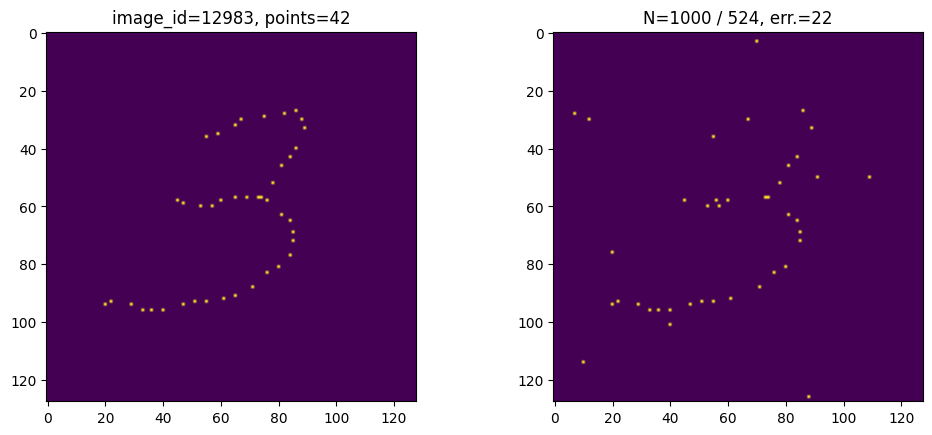

In [26]:
image_id = RNG.choice(df_train_images.index)
image = next(df_train_images.loc[[image_id]].itertuples())
si_ind_dict = pickle.loads(image.inner_si_ind_dict)
sequences = pickle.loads(image.inner_sequences)
seq = get_sequence(sequences)
seq_xy = get_xy_sequence(seq, si_ind_dict)
ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
seq_xy = seq_xy[ii]
ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv_true[ind_seq] = 1

seq_hdv = hdc.bundle(PIXEL_HDVS[ind_seq])
seq_hdv_binary = hdc.to_binary(seq_hdv)
seq_hdv_bipolar = hdc.to_bipolar(seq_hdv_binary)
seq_hdv_bipolar_norm = hdc.normalize(seq_hdv_bipolar)
pixel_hdv_inds = np.argwhere((PIXEL_HDVS_NORM @ seq_hdv_bipolar_norm) > hdc.cos_sim_threshold).ravel()
seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv[pixel_hdv_inds] = 1

error_level = np.count_nonzero(seq_bv != seq_bv_true)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
ax1.imshow(seq_bv_true.reshape(config.sample_size, -1));
ax2.set_title(f'err.={error_level}')
ax2.set_title(f'N={seq_hdv.shape[0]} / {seq_hdv_binary.sum():.0f}, err.={error_level}')
ax2.imshow(seq_bv.reshape(config.sample_size, -1));

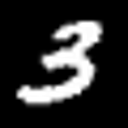

In [27]:
get_raw_image(image_id)

## .lab sbv

In [28]:
# # image_id = RNG.choice(df_train_images.index)
# # image_id = 44917 # 60 points
# image = next(df_train_images.loc[[image_id]].itertuples())
# si_ind_dict = pickle.loads(image.inner_si_ind_dict)
# sequences = pickle.loads(image.inner_sequences)
# seq = get_sequence(sequences)
# seq_xy = get_xy_sequence(seq, si_ind_dict)
# ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
# seq_xy = seq_xy[ii]
# ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
# seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
# seq_bv_true[ind_seq] = 1

# # seq_sbv = np.where(np.sum(PIXEL_SBVS[ind_seq], axis=0) > 0, 1, 0) # aka Bloom filter
# seq_sbv = calc_seq_sbv(seq_xy)
# # pixel_sbv_inds = np.argwhere((PIXEL_SBVS @ seq_sbv) >= SBV_NON_ZERO_INDS).ravel()
# # seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
# # seq_bv[pixel_sbv_inds] = 1
# seq_bv = seq_sbv_to_bv(seq_sbv)

# error_level = np.count_nonzero(seq_bv != seq_bv_true)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(12)
# ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
# ax1.imshow(seq_bv_true.reshape(config.sample_size, -1))
# ax2.set_title(f'sbv={seq_sbv.shape[0]} / {seq_sbv.sum()}, non_zero_inds={HP_SIGNAL_VEC_NON_ZERO_BITS}, err.={error_level}')
# ax2.imshow(seq_bv.reshape(config.sample_size, -1));

# Train

In [29]:
move_to_ooc_transf = np.array([
    [1, 0, -config.sample_size / 2],
    [0, 1, -config.sample_size / 2],
    [0, 0, 1]])
theta = np.deg2rad(45)
cos_theta = math.cos(theta)
sin_theta = math.sin(theta)
rotation_transf = np.array([
    [cos_theta, -sin_theta, 0],
    [sin_theta, cos_theta, 0],
    [0, 0, 1]
])
move_to_target_loc_transf = np.array([
    [1, 0, config.sample_size / 2],
    [0, 1, config.sample_size / 2],
    [0, 0, 1]])
transf_rotate_45 = move_to_target_loc_transf @ rotation_transf @ move_to_ooc_transf

In [30]:
transf_offset_10_0 = np.array([
    [1, 0, 10],
    [0, 1, 0],
    [0, 0, 1]])

In [31]:
transfs = {
    'offset_10_0': transf_offset_10_0,
    'rotate_45': transf_rotate_45,
}
transf_code = 'offset_10_0'
transf = transfs[transf_code]

In [32]:
LOG.is_enabled = True

In [36]:
clear_memory()

In [45]:
HP_MAX_LEARN_CLUSTERS_COUNT = 300_000

# HP_EPOCHS_COUNT = 10
# HP_CYCLES_COUNT = 500
# HP_OUTPUT_BITS_PER_BATCH = 50

# HP_POINTS_COUNT = HP_OUTPUT_BITS_PER_BATCH * 100
# HP_POINT_NON_ZERO_BITS = 100

HP_EPOCHS_COUNT = 1
HP_CYCLES_COUNT = 100
HP_OUTPUT_BITS_PER_BATCH = 256

HP_POINTS_COUNT = HP_OUTPUT_BITS_PER_BATCH * 200
HP_POINT_NON_ZERO_BITS = 32

In [38]:
# cycle_images_count = min(50, len(df_train_images))
cycle_images_count = min(1, len(df_train_images))
use_toy_images = True

In [39]:
# Counter(map(lambda m: m.ones_count, filter(lambda m: m.state == ClusterState.PROD, CLUSTER_METAS.values())))

In [77]:
CLUSTERS2 = HdvArray(HP_SIGNAL_VEC_LEN, np, initial_length=10_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy)
CLUSTER_MASKS2 = HdvArray(HP_SIGNAL_VEC_LEN, np, initial_length=10_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy)

In [78]:
%%time
c = Counter()

for signal_input, signal_output in zip(signals_input, signals_output):
    if learn_cluster_count > HP_MAX_LEARN_CLUSTERS_COUNT:
        break
        
    active_points_mask = signal_output[POINT_OUTPUT_BITS] != 0
    active_point_inds = POINT_INDS[active_points_mask]

    if active_point_inds.shape[0] == 0:
        continue
        
    active_points = POINTS[active_point_inds] # subset of POINTS which are connected to active output bits
    active_points_signal_input_mat = active_points * signal_input
    active_points_signal_input_mask = (active_points_signal_input_mat.sum(axis=1) >= HP_CLUSTER_CREATION_ONES_COUNT_THRES) # active_points must have at least ON bits within input signal
    active_points_signal_input_mask = xp_array_from_gpu(active_points_signal_input_mask)

    for mask_value, point_ind, subsignal_input, subsignal_input_gpu in zip(active_points_signal_input_mask,
                                                                           active_point_inds, 
                                                                           xp_array_from_gpu(active_points_signal_input_mat),
                                                                           active_points_signal_input_mat):
        c[0] += 1
        
        if not mask_value:
            continue

        c[1] += 1
        
        active_output_bit = int(POINT_OUTPUT_BITS[point_ind])
        active_input_bits = np.flatnonzero(subsignal_input)
        assert active_input_bits.shape[0] >= HP_CLUSTER_CREATION_ONES_COUNT_THRES
        cluster_key = get_cluster_key(ClusterState.LEARN.name, active_output_bit, active_input_bits)

        # if cluster_key in unique_cluster_keys:
        #     continue

        # cluster_ind = CLUSTERS.lease()
        # cluster_mask_ind = CLUSTER_MASKS.lease()
        
        cluster_ind = CLUSTERS2.lease()
        cluster_mask_ind = CLUSTER_MASKS2.lease()
        assert cluster_ind == cluster_mask_ind
        
        # CLUSTERS.array[cluster_ind, [1,2,3,4,5,6]] = 1
        # CLUSTER_MASKS.array[cluster_ind, [1,2,3,4,5,6]] = 1

        # CLUSTERS.array[cluster_ind, 1:10] = 1
        # CLUSTER_MASKS.array[cluster_ind, 1:10] = 1

        # CLUSTERS.array[cluster_ind] = subsignal_input_gpu
        # CLUSTER_MASKS.array[cluster_ind] = subsignal_input_gpu

        CLUSTERS2.array[cluster_ind] = subsignal_input
        CLUSTER_MASKS2.array[cluster_ind] = subsignal_input
        
        # cluster_meta = ClusterMeta(cluster_ind)
        # cluster_meta.cluster_key = cluster_key
        # cluster_meta.output_bit = active_output_bit
        # cluster_meta.input_bits = tuple(active_input_bits)
        # cluster_meta.nu = 1 / subsignal_input.sum()
        # cluster_meta.signals_to_learn_till_binarization = HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE[0]
        # cluster_meta.binarization_schedule = HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE
        # cluster_meta.alarm_cycle = cycle + HP_CLUSTER_LEARN_STATE_IDLE_CYCLES
        # CLUSTER_METAS[cluster_ind] = cluster_meta
        # unique_cluster_keys.add(cluster_key)
        new_clusters_count += 1
        learn_cluster_count += 1

c

CPU times: user 253 ms, sys: 19.1 ms, total: 272 ms
Wall time: 270 ms


Counter({0: 8791, 1: 7392})

In [57]:
%%timeit
np.flatnonzero(subsignal_input)

2.44 μs ± 116 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [64]:
%%timeit
list(map(lambda x: x[0], filter(lambda x: x[1], enumerate(subsignal_input))))

24.4 μs ± 306 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [65]:
list(map(lambda x: x[0], filter(lambda x: x[1], enumerate(subsignal_input))))

[59, 90, 109, 116, 253]

In [62]:
qqq = subsignal_input.astype('b')
qqq.dtype

dtype('int8')

In [66]:
# %%timeit
np.flatnonzero(qqq)

array([ 59,  90, 109, 116, 253])

In [43]:
# %%time
batch_output_bits_filter = lambda s, e: True
# batch_output_bits_filter = lambda s, e: s == 0

for epoch in tqdm(range(HP_EPOCHS_COUNT), desc='Epoch'):
    with LOG.auto_prefix('EPOCH', epoch):
        for start_output_bit in range(0, HP_SIGNAL_VEC_LEN, HP_OUTPUT_BITS_PER_BATCH):
            end_output_bit = start_output_bit + HP_OUTPUT_BITS_PER_BATCH - 1
            end_output_bit = min(end_output_bit, HP_SIGNAL_VEC_LEN - 1)
            assert end_output_bit >= start_output_bit, (start_output_bit, end_output_bit)

            if not batch_output_bits_filter(start_output_bit, end_output_bit):
                continue
            
            with LOG.auto_prefix('OBITS', f'{start_output_bit}:{end_output_bit}'):
                clear_memory()

                ## Create combinatorial points from scratch for output bits (OBITS)
                POINTS = []
                POINT_OUTPUT_BITS = []
                output_bits = RNG.choice(range(start_output_bit, end_output_bit + 1), HP_POINTS_COUNT)
                
                for output_bit in output_bits:
                    point_vec = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
                    non_zero_inds = RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINT_NON_ZERO_BITS, replace=False)
                    point_vec[non_zero_inds] = 1
                    POINTS.append(point_vec)
                    POINT_OUTPUT_BITS.append(output_bit)
                
                POINTS = xp_array_to_gpu(np.vstack(POINTS))
                POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
                POINT_INDS = np.arange(POINTS.shape[0])
                LOG(f'{POINTS.shape[0]} combinatorial points created')

                ## Restore prod clusters for output bits (OBITS)
                df_clusters = pd.read_sql('SELECT ROWID, output_bit, sbv, meta FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code ' + 
                                          'AND output_bit>=:start_output_bit AND output_bit<=:end_output_bit', 
                                          params={
                                              'encoding': HP_SIGNAL_ENCODING, 
                                              'transf_code': transf_code,
                                              'start_output_bit': start_output_bit, 
                                              'end_output_bit': end_output_bit}, 
                                          con=transfs_db_con)
                
                for cluster_row in df_clusters.itertuples():
                    prod_clusters_for_output_bit = pickle.loads(cluster_row.sbv)
                    prod_cluster_metas_for_output_bit = pickle.loads(cluster_row.meta)
                    assert prod_clusters_for_output_bit.shape[0] == len(prod_cluster_metas_for_output_bit)

                    for cluster, meta in zip(prod_clusters_for_output_bit, prod_cluster_metas_for_output_bit):
                        cluster = xp_array_to_gpu(cluster)
                        cluster_ind = CLUSTERS.lease()
                        assert CLUSTER_MASKS.lease() == cluster_ind
                        meta.cluster_ind = cluster_ind
                        # meta.cluster_key = get_cluster_key(ClusterState.PROD.name, meta.output_bit, np.flatnonzero(cluster))
                        CLUSTERS.array[cluster_ind] = cluster
                        CLUSTER_MASKS.array[cluster_ind] = cluster
                        CLUSTER_METAS[cluster_ind] = meta

                    LOG(f'Loaded {prod_clusters_for_output_bit.shape[0]} clusters for output bit {cluster_row.output_bit} (ROWID={cluster_row.rowid})')

                assert len(CLUSTER_METAS) == CLUSTERS.active_len
                assert len(CLUSTER_METAS) == CLUSTER_MASKS.active_len
                LOG(f'Loaded {len(CLUSTER_METAS)} clusters in total')

                prod_cluster_metas = filter(lambda c: c.state == ClusterState.PROD, CLUSTER_METAS.values())
                unique_cluster_keys = set(map(lambda m: m.cluster_key, prod_cluster_metas))
                
                ## Mine clusters
                for cycle in tqdm(range(HP_CYCLES_COUNT), leave=False, desc='Cycle'):
                    with LOG.auto_prefix('CYCLE', cycle):
                        ### Prepare input and output signals for training
                        signals_input = []
                        signals_output = []
                        
                        if use_toy_images:
                            cycle_image_ids = get_random_toy_image_ids(cycle_images_count)

                            for cycle_image_id in cycle_image_ids:
                                toy_image_origin = get_toy_image(cycle_image_id)
                                toy_image_transf = np.roll(toy_image_origin.reshape(HP_TOY_IMAGE_SIZE, -1), 1, axis=1).ravel()
                                toy_image_origin_sbv, toy_image_transf_sbv = calc_toy_image_sbv(toy_image_origin), calc_toy_image_sbv(toy_image_transf)
                                signals_input.append(toy_image_origin_sbv)
                                signals_output.append(toy_image_transf_sbv)
                        else:
                            cycle_image_ids = RNG.choice(df_train_images.index, cycle_images_count, replace=False).astype('i')
                            df_cycle_images = df_train_images.loc[cycle_image_ids]
                            
                            for image in df_cycle_images.itertuples():
                                seq_origin_sbv, seq_transf_sbv = get_seq_sbv_pair(image, transf)
                                signals_input.append(seq_origin_sbv)
                                signals_output.append(seq_transf_sbv)
                        
                        signals_input = xp.vstack(signals_input)
                        signals_output = np.vstack(signals_output)
                        ### 
                                         
                        cluster_states = Counter(map(lambda m: m.state.name, CLUSTER_METAS.values()))
                        
                        LOG(f'===')
                        LOG(f'Cycle {cycle} started, clusters: {cluster_states}, CLUSTERS.array.shape={CLUSTERS.array.shape}')
                        
                        ### Create new clusters
                        learn_cluster_count = cluster_states[ClusterState.LEARN.name]
                        new_clusters_count = 0
                        
                        for signal_input, signal_output in zip(signals_input, signals_output):
                            if learn_cluster_count > HP_MAX_LEARN_CLUSTERS_COUNT:
                                break
                                
                            active_points_mask = signal_output[POINT_OUTPUT_BITS] != 0
                            active_point_inds = POINT_INDS[active_points_mask]

                            if active_point_inds.shape[0] == 0:
                                continue
                                
                            active_points = POINTS[active_point_inds] # subset of POINTS which are connected to active output bits
                            active_points_signal_input_mat = active_points * signal_input
                            active_points_signal_input_mask = (active_points_signal_input_mat.sum(axis=1) >= HP_CLUSTER_CREATION_ONES_COUNT_THRES) # active_points must have at least ON bits within input signal
                            active_points_signal_input_mask = xp_array_from_gpu(active_points_signal_input_mask)
                    
                            for mask_value, point_ind, subsignal_input, subsignal_input_gpu in zip(active_points_signal_input_mask,
                                                                                                   active_point_inds, 
                                                                                                   xp_array_from_gpu(active_points_signal_input_mat),
                                                                                                   active_points_signal_input_mat):
                                if not mask_value:
                                    continue
                                
                                active_output_bit = int(POINT_OUTPUT_BITS[point_ind])
                                active_input_bits = np.flatnonzero(subsignal_input)
                                assert active_input_bits.shape[0] >= HP_CLUSTER_CREATION_ONES_COUNT_THRES
                                cluster_key = get_cluster_key(ClusterState.LEARN.name, active_output_bit, active_input_bits)
                    
                                if cluster_key in unique_cluster_keys:
                                    continue
                    
                                cluster_ind = CLUSTERS.lease()
                                cluster_mask_ind = CLUSTER_MASKS.lease()
                                assert cluster_ind == cluster_mask_ind
                                CLUSTERS.array[cluster_ind] = subsignal_input_gpu
                                CLUSTER_MASKS.array[cluster_ind] = subsignal_input_gpu
                                cluster_meta = ClusterMeta(cluster_ind)
                                cluster_meta.cluster_key = cluster_key
                                cluster_meta.output_bit = active_output_bit
                                cluster_meta.input_bits = tuple(active_input_bits)
                                cluster_meta.nu = 1 / subsignal_input.sum()
                                cluster_meta.signals_to_learn_till_binarization = HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE[0]
                                cluster_meta.binarization_schedule = HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE
                                cluster_meta.alarm_cycle = cycle + HP_CLUSTER_LEARN_STATE_IDLE_CYCLES
                                CLUSTER_METAS[cluster_ind] = cluster_meta
                                unique_cluster_keys.add(cluster_key)
                                new_clusters_count += 1
                                learn_cluster_count += 1
                    
                        LOG(f'Created {new_clusters_count} clusters')

                        ### Learn clusters
                        learn_cluster_metas = list(filter(lambda c: c.state == ClusterState.LEARN, CLUSTER_METAS.values()))
                        learn_cluster_inds = np.array(list(map(lambda m: m.cluster_ind, learn_cluster_metas)), dtype='i')
                        learn_cluster_output_bits = np.array(list(map(lambda m: m.output_bit, learn_cluster_metas)), dtype='i')
                        cluster_nus = xp.array(list(map(lambda m: m.nu, CLUSTER_METAS.values())))
                        learned_clusters_inds = set()
                        
                        for signal_input, signal_output in zip(signals_input, signals_output):
                            # this stanza 'signal_output[learn_cluster_output_bits] != 0' effectively produces
                            # boolean mask for learn_cluster_inds - clusters which are connected to currently active output bits
                            active_cluster_inds = learn_cluster_inds[signal_output[learn_cluster_output_bits] != 0]
                    
                            if active_cluster_inds.shape[0] == 0:
                                continue
                            
                            active_clusters = CLUSTERS.array[active_cluster_inds] # subset of CLUSTERS which are connected to active bits in signal_output
                            active_cluster_masks = CLUSTER_MASKS.array[active_cluster_inds]
                            cluster_nus = cluster_nus[active_cluster_inds]

                            ys = signal_input @ active_clusters.T # how each cluster reacted on signal_input (strength), ca. shape (35,).
                            zs = signal_input @ active_cluster_masks.T # number of activated bits within each cluster for given signal_input, ca. shape (35,)
                            grow = (signal_input * (cluster_nus * ys)[:,np.newaxis]) # how weights within each cluster must grow up in response co signal_input, matrix, ca. shape (35, 1024)
                            grow *= active_cluster_masks # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 1024)
                            nomins = active_clusters + grow # grow weights within clusters
                            denoms = nomins.max(axis=1) 
                            updated_active_clusters = (nomins.T / denoms).T 
                            # CLUSTERS.array[active_cluster_inds] = updated_active_clusters # upload updated weights
                            
                            # upload updated weights for those clusters which have enough bits touched by signal
                            # (i.e. we won't update clusters which have e.g. 1 bit touched)
                            zs_mask = xp_array_from_gpu(zs >= HP_CLUSTER_ONES_COUNT_THRES)
                            # CLUSTERS.array[active_cluster_inds] = xp.where(zs_mask[:,np.newaxis], updated_active_clusters, active_clusters) 
                            CLUSTERS.array[active_cluster_inds[zs_mask]] = updated_active_clusters[zs_mask]
                    
                            for cluster_ind in active_cluster_inds[zs_mask]:
                                cluster_meta = CLUSTER_METAS[cluster_ind]
                                cluster_meta.signals_learned += 1
                                cluster_meta.signals_to_learn_till_binarization -= 1
                                cluster_meta.alarm_cycle = cycle + HP_CLUSTER_LEARN_STATE_IDLE_CYCLES
                                learned_clusters_inds.add(cluster_ind)
                    
                        LOG(f'Learned {len(learned_clusters_inds)} clusters')

                        ### Binarize LEARN clusters (develop specialization)
                        cluster_metas_to_binarize = list(filter(lambda m: m.state == ClusterState.LEARN and m.signals_to_learn_till_binarization <= 0, CLUSTER_METAS.values()))
                        cluster_inds_to_binarize = list(map(lambda m: m.cluster_ind, cluster_metas_to_binarize))
                        binarized_clusters = xp.where(CLUSTERS.array[cluster_inds_to_binarize] > HP_CLUSTER_BINARIZE_THRES, 1, 0)
                        CLUSTERS.array[cluster_inds_to_binarize] = binarized_clusters
                        CLUSTER_MASKS.array[cluster_inds_to_binarize] = binarized_clusters
                        binarized_clusters_ones_counts = xp_array_from_gpu(binarized_clusters.sum(axis=1))
                        binarized_clusters = xp_array_from_gpu(binarized_clusters)
                    
                        new_cluster_states = Counter()
                        
                        for cluster_meta, cluster, ones_count in zip(cluster_metas_to_binarize, binarized_clusters, binarized_clusters_ones_counts):
                            cluster_ind = cluster_meta.cluster_ind
                            cluster_meta.binarization_schedule = cluster_meta.binarization_schedule[1:]
                            cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0] if cluster_meta.binarization_schedule else 0
                            cluster_meta.ones_count = int(ones_count)
                            assert cluster_meta.ones_count > 0
                
                            if cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES:
                                old_cluster_key = cluster_meta.cluster_key
                                cluster_meta.input_bits = tuple(np.flatnonzero(cluster))
                                new_cluster_key = get_cluster_key(ClusterState.LEARN.name, cluster_meta.output_bit, cluster_meta.input_bits)

                                if old_cluster_key != new_cluster_key:
                                    if new_cluster_key in unique_cluster_keys:
                                        cluster_meta.state = ClusterState.DEAD
                                        cluster_meta.alarm_cycle = None
                                    else:
                                        cluster_meta.cluster_key = new_cluster_key
                                        unique_cluster_keys.remove(old_cluster_key)
                                        unique_cluster_keys.add(new_cluster_key)
                            else:
                                cluster_meta.state = ClusterState.DEAD
                                cluster_meta.alarm_cycle = None
                                
                            new_cluster_states[cluster_meta.state.name] += 1
                    
                        LOG(f'Binarized {len(cluster_metas_to_binarize)} clusters: {new_cluster_states}')

                        ### Promote LEARN clusters to PREPROD/DEAD if they've learned enough (binarization schedule is exhausted)
                        new_cluster_states = Counter()
                        learn_cluster_metas_to_promote = filter(lambda m: m.state == ClusterState.LEARN and not m.binarization_schedule, CLUSTER_METAS.values())
                        
                        for cluster_meta in learn_cluster_metas_to_promote:
                            cluster_ind = cluster_meta.cluster_ind
                            assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                
                            old_cluster_key = cluster_meta.cluster_key
                            new_cluster_key = get_cluster_key(ClusterState.PROD.name, cluster_meta.output_bit, cluster_meta.input_bits)

                            if new_cluster_key in unique_cluster_keys:
                                cluster_meta.state = ClusterState.DEAD
                                cluster_meta.alarm_cycle = None
                            else:
                                cluster_meta.cluster_key = new_cluster_key
                                cluster_meta.state = ClusterState.PREPROD
                                cluster_meta.alarm_cycle = cycle + HP_CLUSTER_PREPROD_STATE_IDLE_CYCLES
                                unique_cluster_keys.remove(old_cluster_key)
                                unique_cluster_keys.add(new_cluster_key)
                                
                            new_cluster_states[cluster_meta.state.name] += 1

                        LOG(f'Promoted {new_cluster_states.total()} LEARN clusters: {new_cluster_states}')

                        ### Promote PREPROD clusters to PROD/DEAD if they've been verified enough
                        new_cluster_states = Counter()
                        preprod_cluster_metas_to_promote = filter(lambda c: (c.state == ClusterState.PREPROD) and (c.stats.total() >= HP_CLUSTER_PREPROD_STATE_SIGNALS_PROCESSED_THRES), CLUSTER_METAS.values())
                        
                        for cluster_meta in preprod_cluster_metas_to_promote:
                            accuracy = cluster_meta.stats[True] / cluster_meta.stats.total()

                            if accuracy >= HP_CLUSTER_ACCURACY_THRES:
                                assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                                cluster_meta.state = ClusterState.PROD
                                cluster_meta.alarm_cycle = None
                            else:
                                cluster_meta.state = ClusterState.DEAD
                                cluster_meta.alarm_cycle = None
                                
                            new_cluster_states[cluster_meta.state.name] += 1
                    
                        LOG(f'Promoted {new_cluster_states.total()} PREPROD clusters: {new_cluster_states}')
                    
                        ### Verify PREPROD clusters against new signals
                        preprod_cluster_metas = list(filter(lambda m: m.state == ClusterState.PREPROD, CLUSTER_METAS.values()))
                        preprod_cluster_inds = np.array(list(map(lambda m: m.cluster_ind, preprod_cluster_metas)), dtype='i')
                        preprod_cluster_ones_counts = xp.array(list(map(lambda m: m.ones_count, preprod_cluster_metas)), dtype='f')
                        preprod_cluster_output_bits = np.array(list(map(lambda m: m.output_bit, preprod_cluster_metas)), dtype='i')
                        preprod_clusters = CLUSTERS.array[preprod_cluster_inds]
                        verified_cluster_inds = set()
                        
                        for signal_input, signal_output, signal_image_id in zip(signals_input, signals_output, cycle_image_ids):
                            activated_clusters_mask = xp_array_from_gpu((preprod_clusters @ signal_input) >= preprod_cluster_ones_counts)
                            # cast array of output_bit numbers [0, 3, 4, 7, 7, 0, 3, 32, ..] to TP array [True, False, False, True, True, True, False, False, ...]
                            # where True if output_bit of preprod_cluster is enabled in signal_output and False otherwise
                            preprod_cluster_output_bits_tf = signal_output[preprod_cluster_output_bits] != 0
                            
                            for cluster_ind, tf in zip(preprod_cluster_inds[activated_clusters_mask], preprod_cluster_output_bits_tf[activated_clusters_mask]):
                                tf = bool(tf) # not mandatory, but eases further inspections by eyes
                                signal_image_id = int(signal_image_id)
                                cluster_meta = CLUSTER_METAS[cluster_ind]
                    
                                if not signal_image_id in cluster_meta.verify_image_ids:
                                    cluster_meta.stats[tf] += 1
                                    cluster_meta.verify_image_ids[signal_image_id] = tf
                                    cluster_meta.alarm_cycle = cycle + HP_CLUSTER_PREPROD_STATE_IDLE_CYCLES
                                    verified_cluster_inds.add(cluster_ind)
                    
                        LOG(f'Verified {len(verified_cluster_inds)} clusters')
                        
                        ### Weed the garden
                        unneeded_cluster_metas = []
                        unneeded_cluster_metas.extend(filter(lambda m: m.state == ClusterState.DEAD, CLUSTER_METAS.values()))
                        unneeded_cluster_metas.extend(filter(lambda m: m.alarm_cycle is not None and m.alarm_cycle < cycle, CLUSTER_METAS.values()))
                        
                        for cluster_meta in unneeded_cluster_metas:
                            cluster_ind = cluster_meta.cluster_ind
                            unique_cluster_keys.remove(cluster_meta.cluster_key)
                            del CLUSTER_METAS[cluster_ind]
                            CLUSTERS.release(cluster_ind)
                            CLUSTER_MASKS.release(cluster_ind)
                    
                        LOG(f'Removed {len(unneeded_cluster_metas)} loser clusters')

                ## Persist mined prod clusters for output bits (OBITS)
                prod_cluster_metas_per_output_bit = defaultdict(list)
                
                for meta in filter(lambda m: m.state == ClusterState.PROD, CLUSTER_METAS.values()):
                    prod_cluster_metas_per_output_bit[meta.output_bit].append(meta)

                for output_bit, metas in prod_cluster_metas_per_output_bit.items():
                    cluster_inds = np.array(list(map(lambda m: m.cluster_ind, metas)), dtype='i')
                    # Leave only super clusters, i.e. clusters which are not subsets of any other clusters
                    clusters = CLUSTERS.array[cluster_inds]
                    crossings = (clusters @ clusters.T)
                    cluster_ones_counts = clusters.sum(axis=1)
                    crossings[xp.diag_indices_from(crossings)] = 0
                    super_clusters_mask = ~xp.any((crossings.T >= cluster_ones_counts).T, axis=1)

                    clusters = xp_array_from_gpu(clusters[super_clusters_mask])
                    super_clusters_mask = xp_array_from_gpu(super_clusters_mask)
                    
                    pickled_clusters = pickle.dumps(clusters)
                    pickled_metas = pickle.dumps(list(map(lambda x: x[1], filter(lambda x: x[0], zip(super_clusters_mask, metas)))))
                    # Changing autocommit to False will open a new transaction, and changing it to True will commit any pending transaction.
                    # https://docs.python.org/3/library/sqlite3.html#connection-objects
                    transfs_db_con.autocommit = False
                    transfs_db_con.execute('DELETE FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code AND output_bit=:output_bit',
                                           {'encoding': HP_SIGNAL_ENCODING, 'transf_code': transf_code, 'output_bit': output_bit})
                    transfs_db_con.execute('INSERT INTO clusters (encoding, transf_code, output_bit, sbv, meta) VALUES (:encoding, :transf_code, :output_bit, :sbv, :meta)',
                                           {'encoding': HP_SIGNAL_ENCODING, 'transf_code': transf_code, 'output_bit': output_bit, 'sbv': pickled_clusters, 'meta': pickled_metas})
                    transfs_db_con.autocommit = True
                    LOG(f'Persisted {clusters.shape[0]} super clusters for output bit {output_bit} of total {cluster_inds.shape[0]} clusters')

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Cycle:   0%|          | 0/100 [00:00<?, ?it/s]

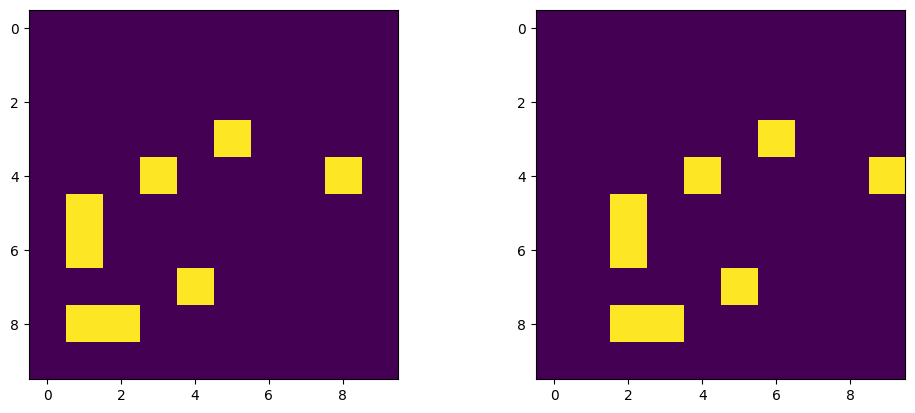

In [118]:
signal_ind = RNG.choice(signals_input.shape[0])
# signal_ind = 0
signal_input = xp_array_from_gpu(signals_input[signal_ind])
signal_output = signals_output[signal_ind]

if use_toy_images:
    signal_input = toy_image_sbv_to_bv(signal_input)
    signal_output = toy_image_sbv_to_bv(signal_output)
else:
    signal_input = seq_sbv_to_bv(signal_input)
    signal_output = seq_sbv_to_bv(signal_output)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.imshow(vec_to_square_matrix(signal_input))
ax2.imshow(vec_to_square_matrix(signal_output));

# Test

In [110]:
clear_memory(with_caches=True)

df_clusters = pd.read_sql('SELECT output_bit, sbv, meta FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code', 
                          params={
                              'encoding': HP_SIGNAL_ENCODING, 
                              'transf_code': transf_code},
                          con=transfs_db_con)
                
for cluster_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
    prod_clusters_for_output_bit = pickle.loads(cluster_row.sbv)
    prod_cluster_metas_for_output_bit = pickle.loads(cluster_row.meta)

    for cluster, meta in zip(prod_clusters_for_output_bit, prod_cluster_metas_for_output_bit):
        cluster = xp_array_to_gpu(cluster)
        cluster_ind = CLUSTERS.lease()
        assert CLUSTER_MASKS.lease() == cluster_ind
        meta.cluster_ind = cluster_ind
        CLUSTERS.array_active[cluster_ind] = cluster
        CLUSTER_MASKS.array_active[cluster_ind] = cluster
        CLUSTER_METAS[cluster_ind] = meta

len(CLUSTER_METAS), CLUSTERS.array_active.shape

  0%|          | 0/200 [00:00<?, ?it/s]

(57790, (57790, 256))

In [111]:
# prod_cluster_metas = list(filter(lambda c: c.state == ClusterState.PROD and c.stats[True] > 5, CLUSTER_METAS.values()))
prod_cluster_metas = list(filter(lambda c: c.state == ClusterState.PROD, CLUSTER_METAS.values()))
prod_cluster_inds = np.array(list(map(lambda c: c.cluster_ind, prod_cluster_metas)), dtype='i')
prod_cluster_ones_counts = xp.array(list(map(lambda c: c.ones_count, prod_cluster_metas)), dtype='f')
prod_cluster_output_bits = np.array(list(map(lambda c: c.output_bit, prod_cluster_metas)), dtype='i')
prod_clusters = CLUSTERS.array_active[prod_cluster_inds]
prod_clusters.shape

(57790, 256)

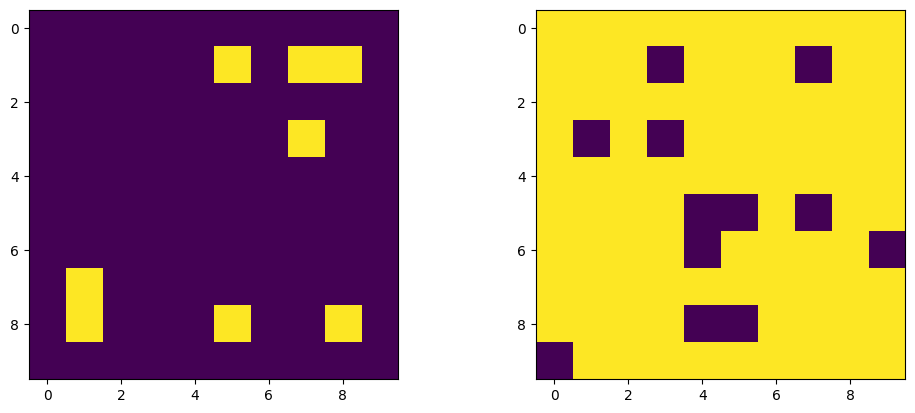

In [142]:
toy_image_id = get_random_toy_image_ids(1)[0]
toy_image = get_toy_image(toy_image_id)

toy_image_sbv = calc_toy_image_sbv(toy_image)
toy_image_sbv = xp_array_to_gpu(toy_image_sbv)

activated_clusters_mask = (prod_clusters @ toy_image_sbv) >= prod_cluster_ones_counts
activated_clusters_mask = xp_array_from_gpu(activated_clusters_mask)
values = Counter(prod_cluster_output_bits[activated_clusters_mask])
toy_image_sbv_out = np.zeros_like(toy_image_sbv)
toy_image_sbv_out[list(values.keys())] = list(values.values())
# toy_image_sbv_out = np.where(toy_image_sbv_out > 1, 1, 0)
# toy_image_sbv_out[list(values.keys())] = 1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.imshow(vec_to_square_matrix(toy_image_sbv_to_bv(toy_image_sbv)))
ax2.imshow(vec_to_square_matrix(toy_image_sbv_to_bv(toy_image_sbv_out)));

In [144]:
np.unique_counts(toy_image_sbv_out.get())

UniqueCountsResult(values=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  12,  14,  15,  23,
        24,  28,  30,  34,  36,  37,  40,  47,  48,  49,  50,  53,  54,
        55,  57,  58,  61,  63,  64,  66,  67,  68,  69,  70,  75,  78,
        83,  84, 105, 113, 187]), counts=array([174,  17,  10,   1,   4,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   2,   1,   1,   1,   5,   2,   3,   2,   1,
         1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,
         2,   1,   1,   1,   1]))

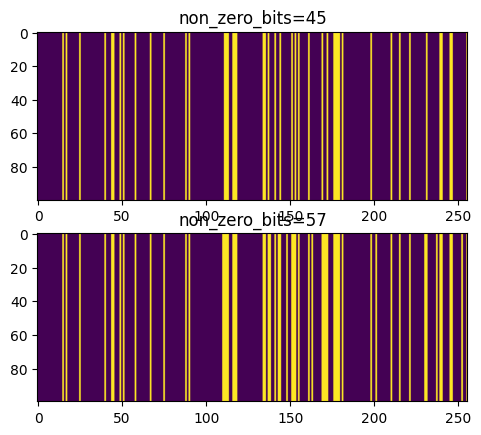

In [138]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(16)

toy_image_transf = np.roll(toy_image.reshape(HP_TOY_IMAGE_SIZE, -1), 1, axis=1).ravel()
toy_image_transf_sbv = calc_toy_image_sbv(toy_image_transf)

ax1.set_title(f'non_zero_bits={toy_image_transf_sbv.sum()}')
ax1.imshow(np.ones((100, 1)) * xp_array_from_gpu(toy_image_transf_sbv));
ax2.set_title(f'non_zero_bits={toy_image_sbv_out.sum()}')
ax2.imshow(np.ones((100, 1)) * xp_array_from_gpu(toy_image_sbv_out));